In [114]:
import scanpy as sc
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

warnings.filterwarnings("ignore")

Uncomment the cell below if you run this notebook for the first time

In [115]:
# %pip install "abc_atlas_access[notebooks] @ git+https://github.com/alleninstitute/abc_atlas_access.git"

In [116]:
adata_hyv2= anndata.read_h5ad("../data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-log2.h5ad",backed=None) # sparse matrix with backed='r'

print(adata_hyv2)

print("\n\n-----Obs header-----\n\n",adata_hyv2.obs.head())
print("\n\n-----Var header-----\n\n",adata_hyv2.var.head())

AnnData object with n_obs × n_vars = 100562 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


-----Obs header-----

                               cell_barcode       library_label  \
cell_label                                                       
AACGTTGAGGCTAGCA-063_E01  AACGTTGAGGCTAGCA  L8TX_181031_01_E08   
GCATGATAGGGATGGG-062_C01  GCATGATAGGGATGGG  L8TX_181019_01_G06   
AGGGTGAGTGAAAGAG-026_A01  AGGGTGAGTGAAAGAG  L8TX_180504_01_F01   
GAGTCCGTCCGCGCAA-026_B01  GAGTCCGTCCGCGCAA  L8TX_180504_01_G01   
AGCCTAAAGCCGCCTA-026_A01  AGCCTAAAGCCGCCTA  L8TX_180504_01_F01   

                         anatomical_division_label  
cell_label                                          
AACGTTGAGGCTAGCA-063_E01                        HY  
GCATGATAGGGATGGG-062_C01                        HY  
AGGGTGAGTGAAAGAG-026_A01                        HY  
GAGTCCGTCCGCGCAA-026_B01            

In [117]:
print(type(adata_hyv2.X))
print(adata_hyv2.X.shape)
print(adata_hyv2.obs.columns)

<class 'scipy.sparse._csr.csr_matrix'>
(100562, 32285)
Index(['cell_barcode', 'library_label', 'anatomical_division_label'], dtype='object')



### 🔹 `n_genes_by_counts`

> **Meaning**: The number of genes **with non-zero expression** detected in each cell.

* Also known as the **gene complexity** or **gene richness** of a cell.
* Low values suggest poor-quality cells or empty droplets.
* Very high values may indicate **doublets** (two cells captured together).

📈 **Use in Violin Plot**:

* Helps identify cells that might be biologically uninteresting or problematic.
* You typically want a **unimodal distribution** centered at a reasonable gene count (e.g., 1000–6000 depending on the protocol).

---

### 🔹 `total_counts`

> **Meaning**: The total number of **transcript counts** (UMIs or reads) for each cell.

* Indicates **cellular RNA content**.
* Low counts: poor cell capture or degraded RNA.
* Very high counts: potential **doublets**, apoptotic cells, or overamplification.

📈 **Use in Violin Plot**:

* Like `n_genes_by_counts`, it helps spot outliers.
* You can visualize batch effects or compare regions if you group by `'library_label'`, `'region'`, etc.

---

### 🔹 `pct_counts_in_top_100_genes`

> **Meaning**: The **percentage of total counts** in a cell that come from the **top 100 most-expressed genes** in that cell.

* High values can indicate:

  * **Overamplification** of a few genes
  * **Low RNA complexity**
  * Potential technical artifacts (e.g., ribosomal/mitochondrial overexpression)

📈 **Use in Violin Plot**:

* You ideally want **moderate** values here.
* Very high values (>50–70%) may indicate bad-quality or damaged cells.
* Often used alongside mitochondrial gene percentages (`pct_counts_mt`) — which Allen Brain Atlas files don’t include by default.

---

## 🧪 QC Summary Table

| Key                     | Good Values    | Flags                         |
| ----------------------- | -------------- | ----------------------------- |
| `n_genes_by_counts`     | \~1000–6000    | <500 (bad), >7000 (doublet)   |
| `total_counts`          | \~1000–30,000  | <1000 (bad), >50k (doublet)   |
| `pct_counts_in_top_100` | <50% (usually) | >60–70% (overexpression bias) |



In [118]:
sc.pp.calculate_qc_metrics(adata_hyv2, inplace=True)

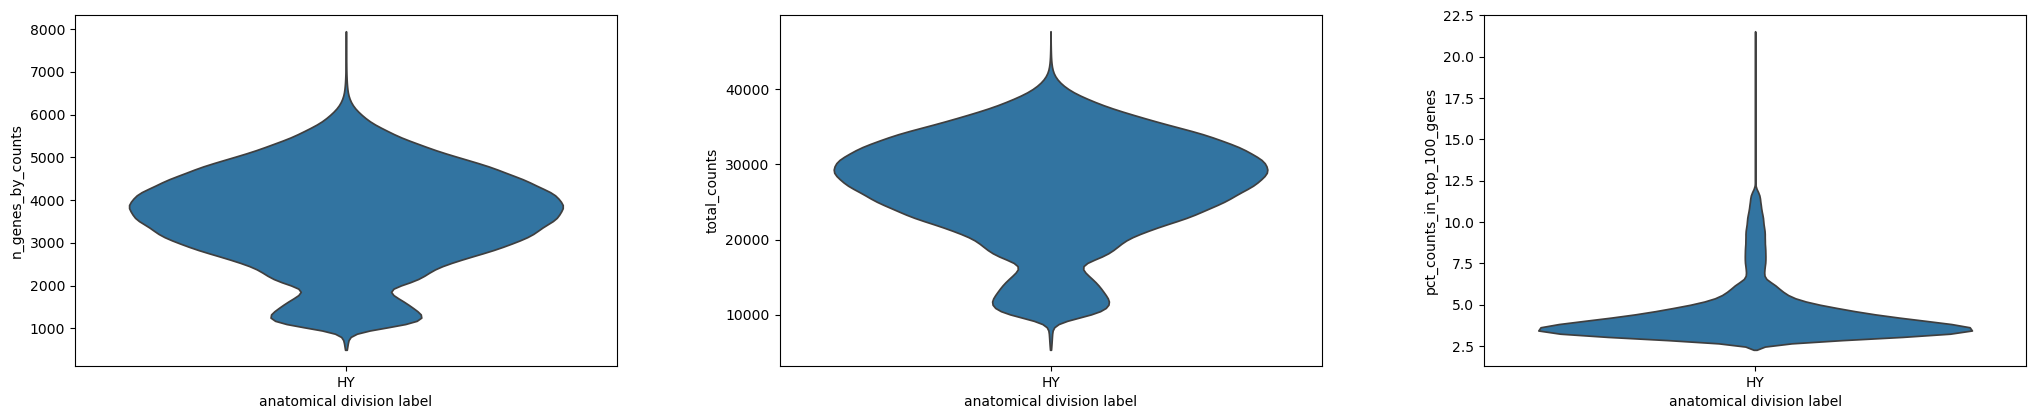

In [119]:
sc.pl.violin(
    adata_hyv2,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='anatomical_division_label',
    jitter=0.4,
    stripplot=False
)

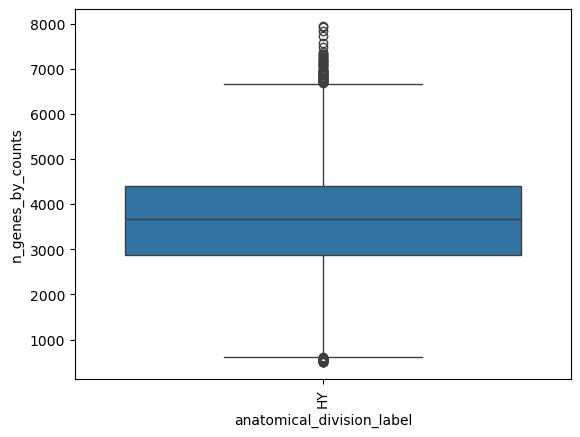

In [120]:
sns.boxplot(data=adata_hyv2.obs, x='anatomical_division_label', y='n_genes_by_counts')
plt.xticks(rotation=90)
plt.show()

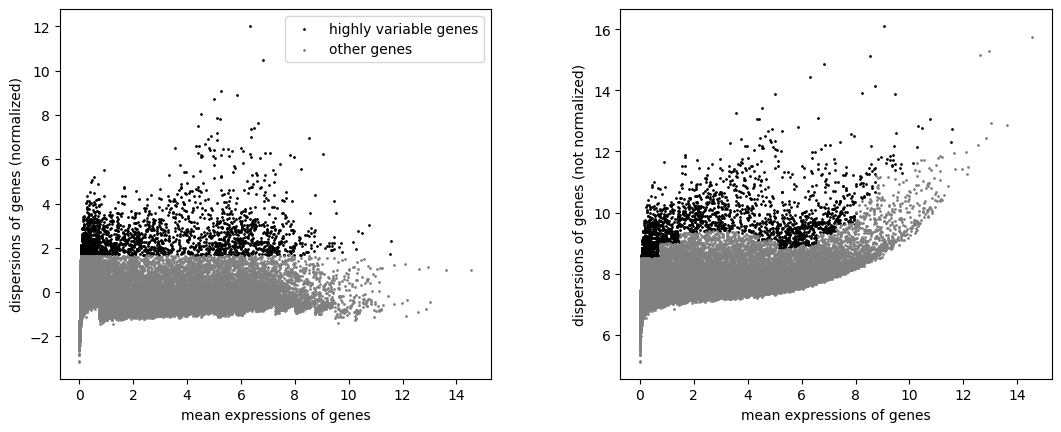

In [121]:
sc.pp.highly_variable_genes(adata_hyv2, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata_hyv2)

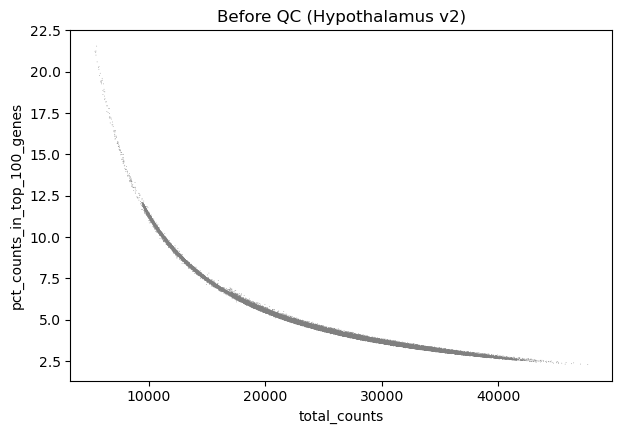

In [122]:
sc.pl.scatter(adata_hyv2, x='total_counts', y='pct_counts_in_top_100_genes',title="Before QC (Hypothalamus v2)")

In [123]:
# Filter out likely dead or damaged cells
adata_hyv2 = adata_hyv2[adata_hyv2.obs['n_genes_by_counts'] > 500, :]
adata_hyv2 = adata_hyv2[adata_hyv2.obs['total_counts'] > 1000, :]

# Optional: Remove overly complex cells (possible doublets)
adata_hyv2 = adata_hyv2[adata_hyv2.obs['n_genes_by_counts'] < 7000, :]

In [124]:
# Filter low information genes
sc.pp.filter_genes(adata_hyv2, min_cells=3)  # Keep genes expressed in at least 3 cells

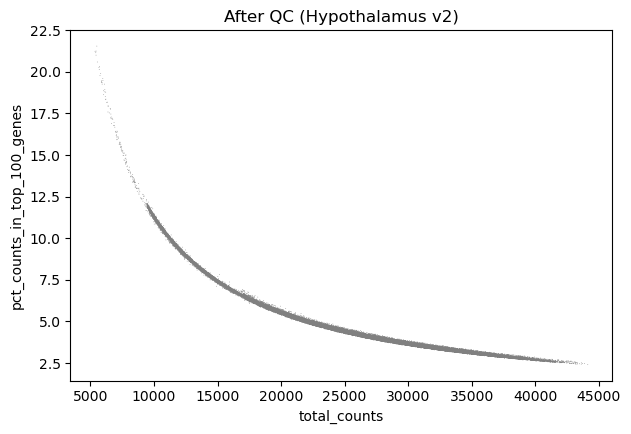

In [125]:
# View percent of counts in top genes (can indicate overamplification)
sc.pl.scatter(adata_hyv2, x='total_counts', y='pct_counts_in_top_100_genes',title="After QC (Hypothalamus v2)")

In [126]:
adata_thv2= anndata.read_h5ad("../data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad",backed=None) # sparse matrix with backed='r'

print(adata_thv2)

# print(adata.X)
print("\n\n-----Obs header-----\n\n",adata_thv2.obs.head())
print("\n\n-----Var header-----\n\n",adata_thv2.var.head())


AnnData object with n_obs × n_vars = 131212 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


-----Obs header-----

                               cell_barcode       library_label  \
cell_label                                                       
CAGGTGCAGGCTAGCA-040_C01  CAGGTGCAGGCTAGCA  L8TX_180815_01_E08   
TGCGCAGGTTGCGCAC-045_C01  TGCGCAGGTTGCGCAC  L8TX_180829_01_C10   
CGATGTATCTTGCCGT-042_B01  CGATGTATCTTGCCGT  L8TX_180829_01_B09   
GACTAACGTCCTCTTG-040_B01  GACTAACGTCCTCTTG  L8TX_180815_01_D08   
GATCGTACAACTGCTA-040_B01  GATCGTACAACTGCTA  L8TX_180815_01_D08   

                         anatomical_division_label  
cell_label                                          
CAGGTGCAGGCTAGCA-040_C01                        TH  
TGCGCAGGTTGCGCAC-045_C01                        TH  
CGATGTATCTTGCCGT-042_B01                        TH  
GACTAACGTCCTCTTG-040_B01            

In [127]:
print(type(adata_thv2.X))
print(adata_thv2.X.shape)
print(adata_thv2.obs.columns)

<class 'scipy.sparse._csr.csr_matrix'>
(131212, 32285)
Index(['cell_barcode', 'library_label', 'anatomical_division_label'], dtype='object')


In [128]:
sc.pp.calculate_qc_metrics(adata_thv2, inplace=True)

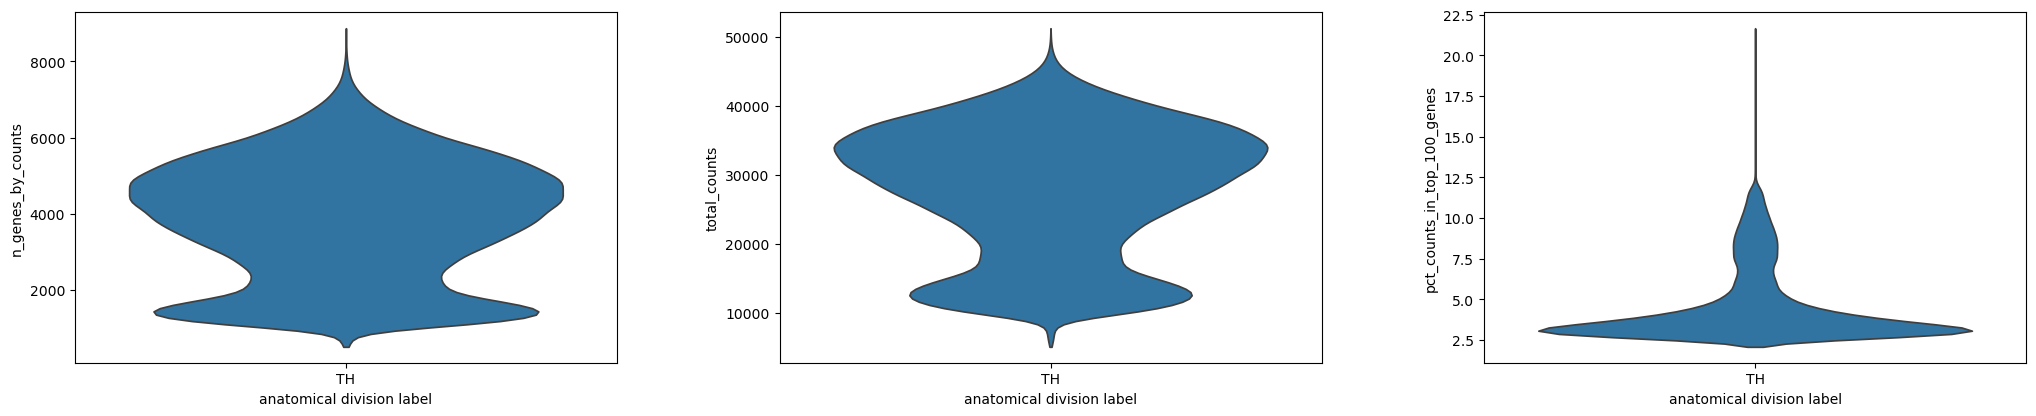

In [129]:
sc.pl.violin(
    adata_thv2,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='anatomical_division_label',
    jitter=0.4,
    stripplot=False
)

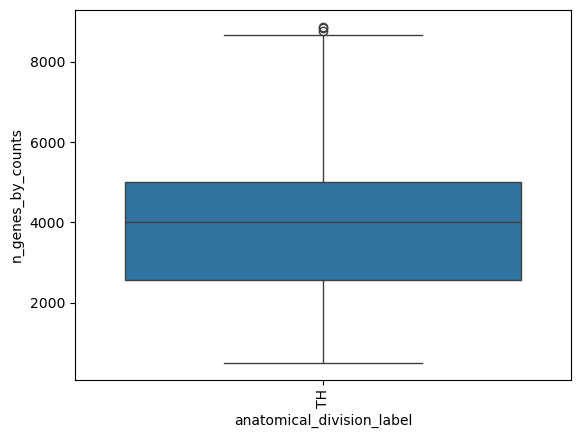

In [130]:
sns.boxplot(data=adata_thv2.obs, x='anatomical_division_label', y='n_genes_by_counts')
plt.xticks(rotation=90)
plt.show()

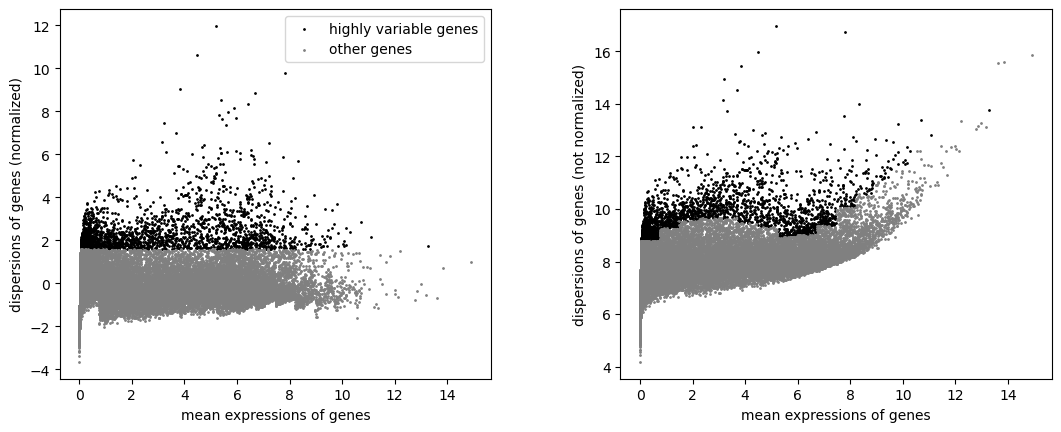

In [131]:
sc.pp.highly_variable_genes(adata_thv2, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata_thv2)

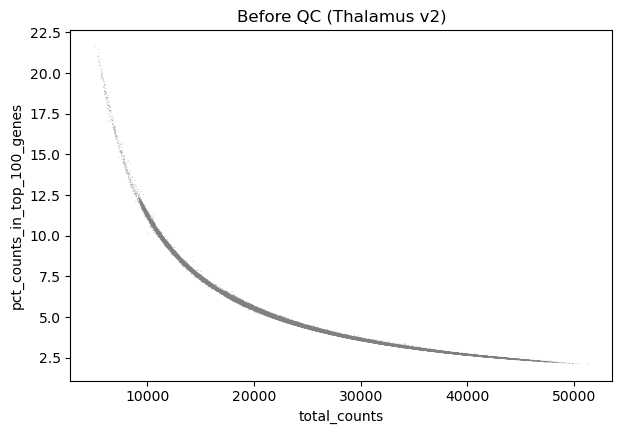

In [132]:
sc.pl.scatter(adata_thv2, x='total_counts', y='pct_counts_in_top_100_genes',title="Before QC (Thalamus v2)")

Some quality control

In [133]:
# Filter out likely dead or damaged cells
adata_thv2 = adata_thv2[adata_thv2.obs['n_genes_by_counts'] > 500, :]
adata_thv2 = adata_thv2[adata_thv2.obs['total_counts'] > 1000, :]

# Optional: Remove overly complex cells (possible doublets)
adata_thv2 = adata_thv2[adata_thv2.obs['n_genes_by_counts'] < 7000, :]

In [134]:
# Filter low information genes
sc.pp.filter_genes(adata_thv2, min_cells=3)  # Keep genes expressed in at least 3 cells

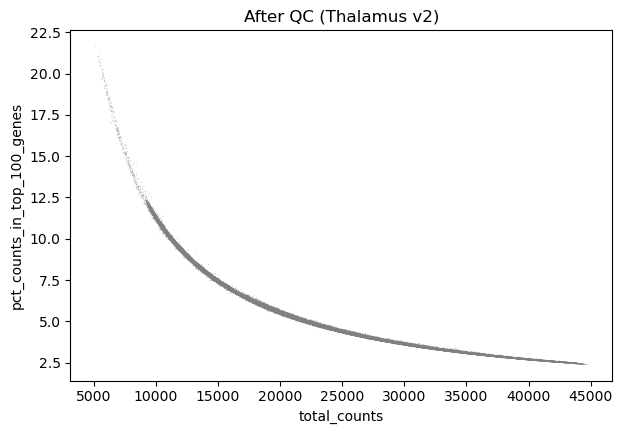

In [135]:
# View percent of counts in top genes (can indicate overamplification)
sc.pl.scatter(adata_thv2, x='total_counts', y='pct_counts_in_top_100_genes',title="After QC (Thalamus v2)")

In [136]:
# We join the two regions and plot
adata_thv2.obs['region']='Thalamus'
adata_hyv2.obs['region']='Hypothalamus'
adata_combinedv2=adata_thv2.concatenate(adata_hyv2)

In [137]:
del adata_thv2,adata_hyv2

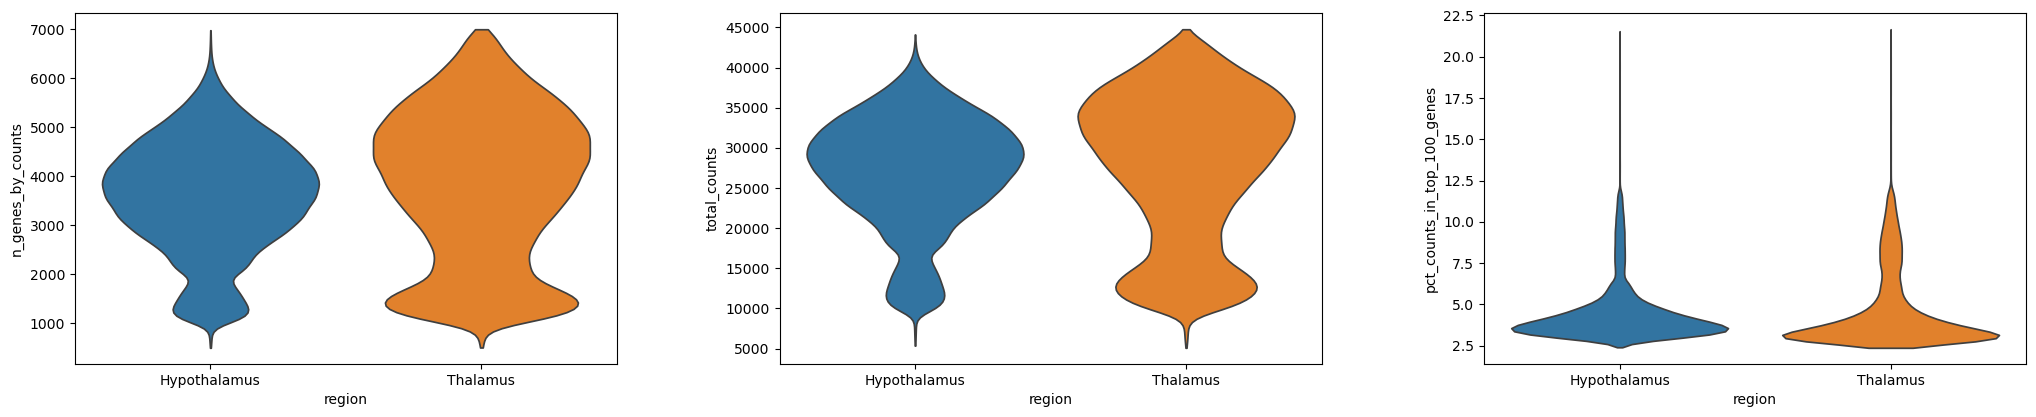

In [138]:
sc.pl.violin(
    adata_combinedv2,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='region',
    jitter=0.4,
    stripplot=False
)

In [139]:
del adata_combinedv2

In [140]:
adata_hyv3= anndata.read_h5ad("../data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-HY-log2.h5ad",backed=None) # sparse matrix with backed='r'

print(adata_hyv3)

print("\n\n-----Obs header-----\n\n",adata_hyv3.obs.head())
print("\n\n-----Var header-----\n\n",adata_hyv3.var.head())

AnnData object with n_obs × n_vars = 162869 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


-----Obs header-----

                               cell_barcode       library_label  \
cell_label                                                       
TGAGGGACACCAAATC-392_A04  TGAGGGACACCAAATC  L8TX_201015_01_B03   
AACGGGAGTACGTGAG-469_A03  AACGGGAGTACGTGAG  L8TX_201217_01_F06   
GCTACAAAGACCATTC-326_D05  GCTACAAAGACCATTC  L8TX_200813_01_G10   
CCGAACGGTGCCTTCT-392_C04  CCGAACGGTGCCTTCT  L8TX_201015_01_E02   
CTTAGGAAGGACAAGA-577_A03  CTTAGGAAGGACAAGA  L8TX_210325_01_H07   

                         anatomical_division_label  
cell_label                                          
TGAGGGACACCAAATC-392_A04                        HY  
AACGGGAGTACGTGAG-469_A03                        HY  
GCTACAAAGACCATTC-326_D05                        HY  
CCGAACGGTGCCTTCT-392_C04            

In [141]:
print(type(adata_hyv3.X))
print(adata_hyv3.X.shape)
print(adata_hyv3.obs.columns)

<class 'scipy.sparse._csr.csr_matrix'>
(162869, 32285)
Index(['cell_barcode', 'library_label', 'anatomical_division_label'], dtype='object')


In [142]:
sc.pp.calculate_qc_metrics(adata_hyv3, inplace=True)

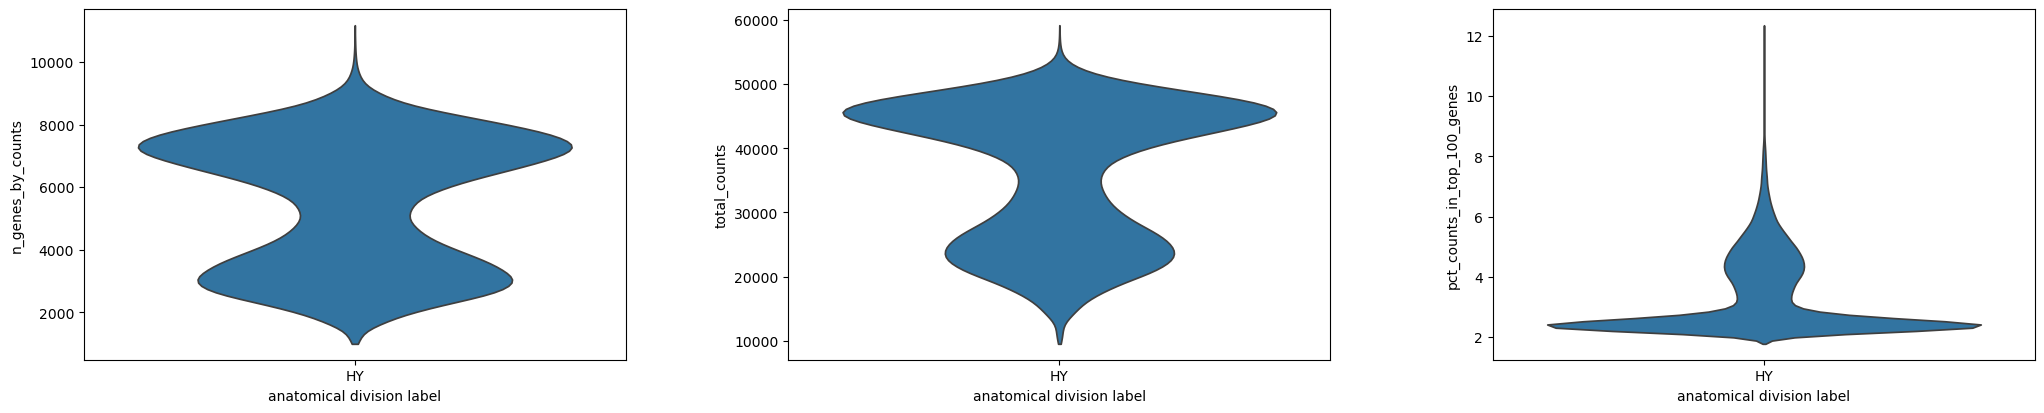

In [143]:
sc.pl.violin(
    adata_hyv3,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='anatomical_division_label',
    jitter=0.4,
    stripplot=False
)

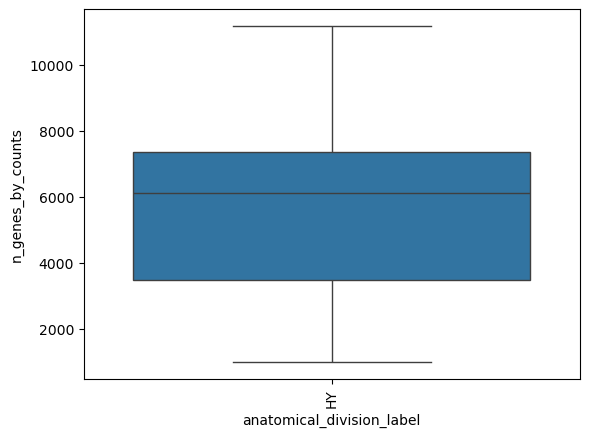

In [144]:
sns.boxplot(data=adata_hyv3.obs, x='anatomical_division_label', y='n_genes_by_counts')
plt.xticks(rotation=90)
plt.show()

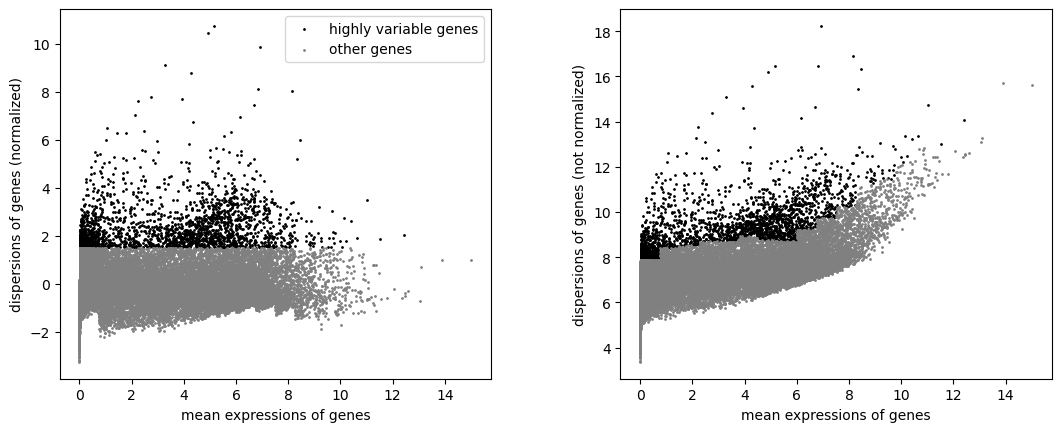

In [145]:
sc.pp.highly_variable_genes(adata_hyv3, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata_hyv3)

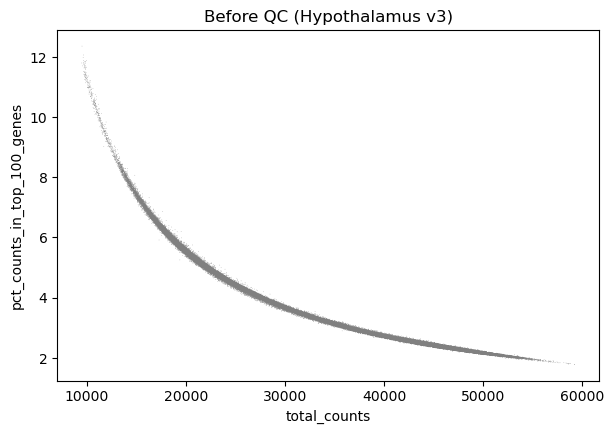

In [146]:
sc.pl.scatter(adata_hyv3, x='total_counts', y='pct_counts_in_top_100_genes',title="Before QC (Hypothalamus v3)")

Some quality control

In [147]:
# Filter out likely dead or damaged cells
adata_hyv3 = adata_hyv3[adata_hyv3.obs['n_genes_by_counts'] > 500, :]
adata_hyv3 = adata_hyv3[adata_hyv3.obs['total_counts'] > 1000, :]

# Optional: Remove overly complex cells (possible doublets)
adata_hyv3 = adata_hyv3[adata_hyv3.obs['n_genes_by_counts'] < 7000, :]

In [148]:
# Filter low information genes
sc.pp.filter_genes(adata_hyv3, min_cells=3)  # Keep genes expressed in at least 3 cells

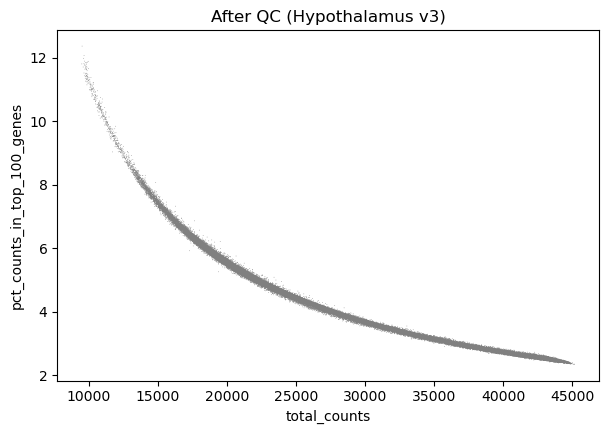

In [149]:
# View percent of counts in top genes (can indicate overamplification)
sc.pl.scatter(adata_hyv3, x='total_counts', y='pct_counts_in_top_100_genes',title="After QC (Hypothalamus v3)")

In [150]:
adata_thv3= anndata.read_h5ad("../data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-TH-log2.h5ad",backed=None) # sparse matrix with backed='r'

print(adata_thv3)

# print(adata.X)
print("\n\n-----Obs header-----\n\n",adata_thv3.obs.head())
print("\n\n-----Var header-----\n\n",adata_thv3.var.head())

AnnData object with n_obs × n_vars = 130856 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


-----Obs header-----

                               cell_barcode       library_label  \
cell_label                                                       
AGAAGTATCATTACGG-290_B01  AGAAGTATCATTACGG  L8TX_200716_01_B06   
TTGACCCCAGGCCTGT-290_B01  TTGACCCCAGGCCTGT  L8TX_200716_01_B06   
AATGCCATCGCTAATG-290_B01  AATGCCATCGCTAATG  L8TX_200716_01_B06   
TGCGATAAGTCATGGG-290_B01  TGCGATAAGTCATGGG  L8TX_200716_01_B06   
CATCCCAAGATCCGAG-294_B05  CATCCCAAGATCCGAG  L8TX_200716_01_H06   

                         anatomical_division_label  
cell_label                                          
AGAAGTATCATTACGG-290_B01                        TH  
TTGACCCCAGGCCTGT-290_B01                        TH  
AATGCCATCGCTAATG-290_B01                        TH  
TGCGATAAGTCATGGG-290_B01            

In [151]:
print(type(adata_thv3.X))
print(adata_thv3.X.shape)
print(adata_thv3.obs.columns)

<class 'scipy.sparse._csr.csr_matrix'>
(130856, 32285)
Index(['cell_barcode', 'library_label', 'anatomical_division_label'], dtype='object')


In [152]:
sc.pp.calculate_qc_metrics(adata_thv3, inplace=True)

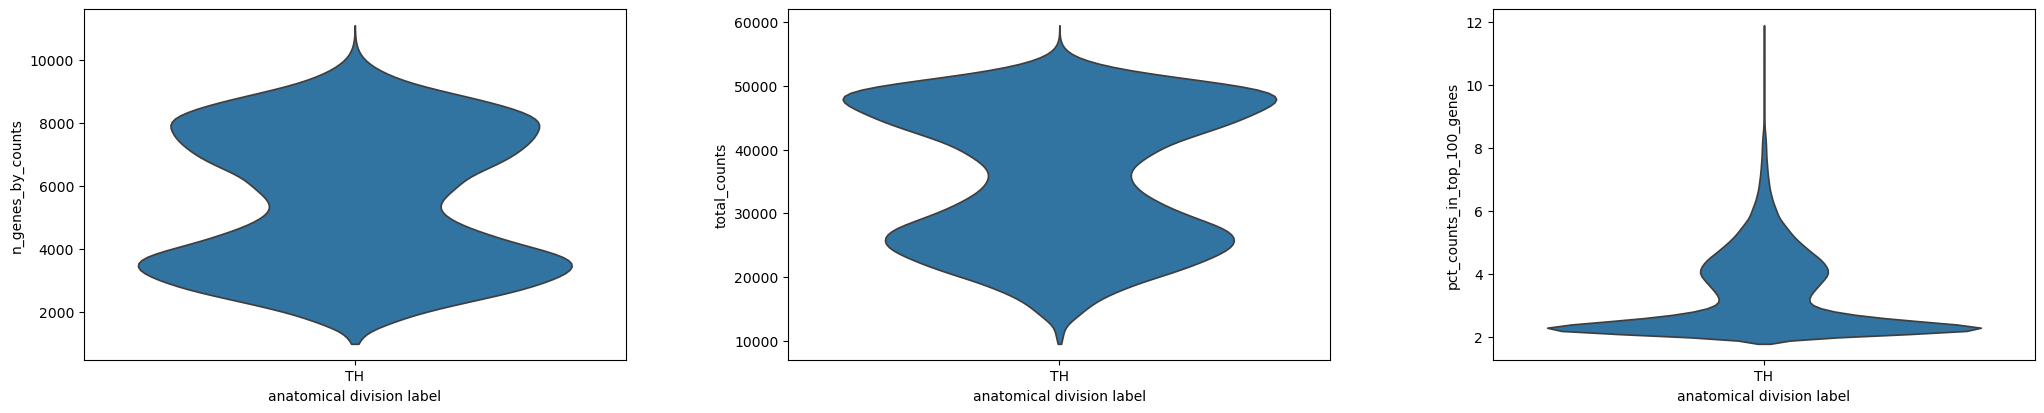

In [153]:
sc.pl.violin(
    adata_thv3,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='anatomical_division_label',
    jitter=0.4,
    stripplot=False
)

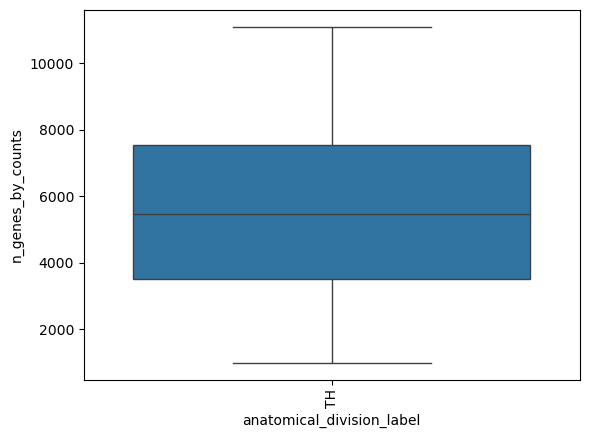

In [154]:
sns.boxplot(data=adata_thv3.obs, x='anatomical_division_label', y='n_genes_by_counts')
plt.xticks(rotation=90)
plt.show()

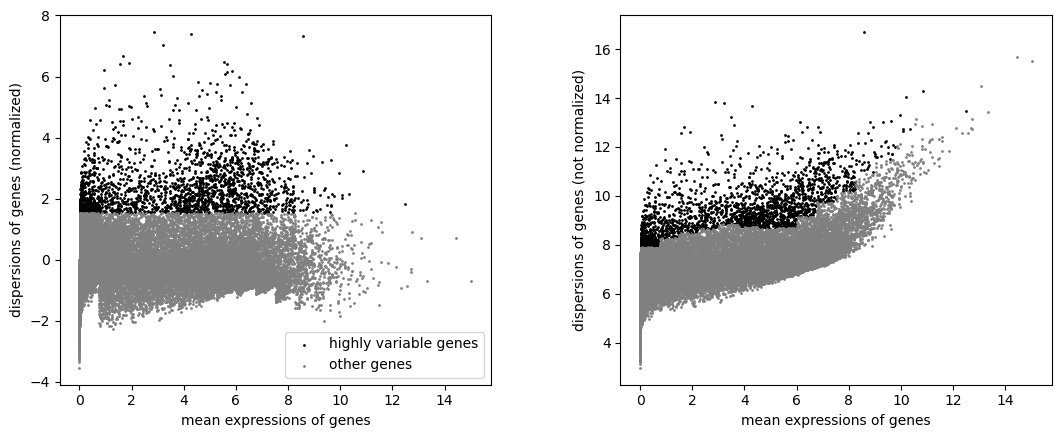

In [155]:
sc.pp.highly_variable_genes(adata_thv3, flavor='seurat', n_top_genes=2000)
sc.pl.highly_variable_genes(adata_thv3)

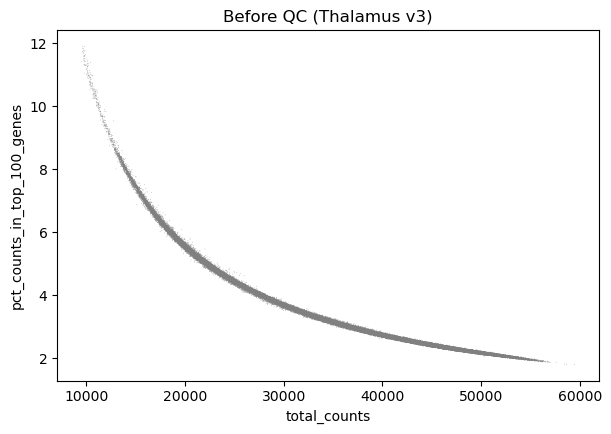

In [156]:
sc.pl.scatter(adata_thv3, x='total_counts', y='pct_counts_in_top_100_genes',title="Before QC (Thalamus v3)")

Some quality control

In [157]:
# Filter out likely dead or damaged cells
adata_thv3 = adata_thv3[adata_thv3.obs['n_genes_by_counts'] > 500, :]
adata_thv3 = adata_thv3[adata_thv3.obs['total_counts'] > 1000, :]

# Optional: Remove overly complex cells (possible doublets)
adata_thv3 = adata_thv3[adata_thv3.obs['n_genes_by_counts'] < 7000, :]

In [158]:
# Filter low information genes
sc.pp.filter_genes(adata_thv3, min_cells=3)  # Keep genes expressed in at least 3 cells

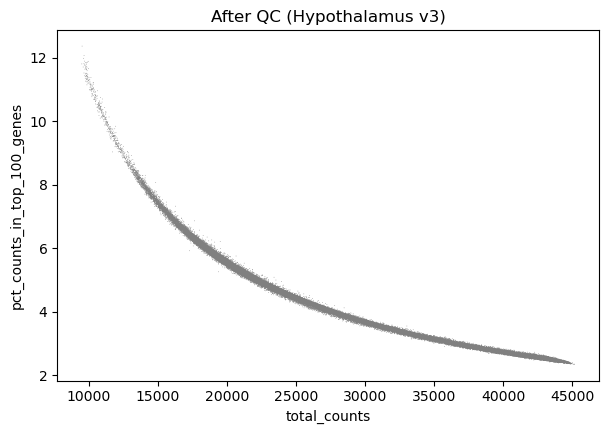

In [159]:
# View percent of counts in top genes (can indicate overamplification)
sc.pl.scatter(adata_hyv3, x='total_counts', y='pct_counts_in_top_100_genes',title="After QC (Hypothalamus v3)")

In [160]:
# We join the two regions and plot
adata_thv3.obs['region']='Thalamus'
adata_hyv3.obs['region']='Hypothalamus'
adata_combinedv3=adata_thv3.concatenate(adata_hyv3)

In [161]:
del adata_thv3,adata_hyv3

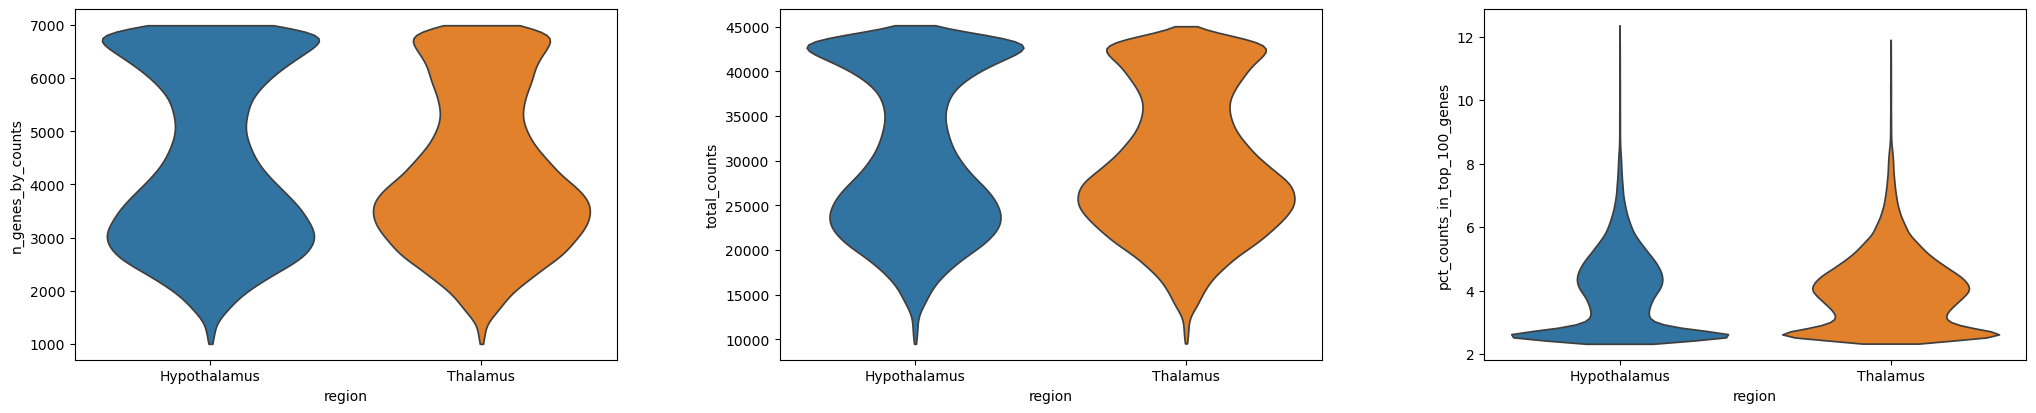

In [162]:
sc.pl.violin(
    adata_combinedv3,
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes'],
    groupby='region',
    jitter=0.4,
    stripplot=False
)

In [164]:
del adata_combinedv3

In [165]:
metadf=pd.read_csv("../data/abc_atlas/metadata/WMB-10X/20230630/region_of_interest_metadata.csv")
metadf.head()

,acronym,label,name,order,color_hex_triplet
0,MO-FRP,WMB-MO-FRP,Somatomotor - Frontal pole,0,#3DCC7C
1,MOp,WMB-MOp,Primary motor area,1,#179968
2,SS-GU-VISC,WMB-SS-GU-VISC,Somatosensory/gustatory/visceral areas,2,#2E8599
3,SSp,WMB-SSp,Primary somatosensory area,3,#5CCCCC
4,AUD,WMB-AUD,Auditory areas,4,#455A99


In [166]:
del metadf